在深入训练机器学习模型之前，我们首先应该看一些实例，以及每个类别的新闻和标题：

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import jieba as jb
import re
df = pd.read_csv('./data/36kr20200506.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: './data/36kr20200506.csv'

对于这个项目，我们只需要三栏——['category', 'content','title]

输入： content+title

实例：「编者按：本文来自微信公众号“大摩财经”（ID：damofinance），撰文 | 蔚然，36... 」 这里有省略

输出：category

实例：金融



In [2]:
from io import StringIO
col = ['category', 'content','title']
df = df[col]
df = df[pd.notnull(df['content'])]
df.columns = ['category', 'content','title']
df.head()

,category,content,title
0,金融,编者按：本文来自微信公众号“大摩财经”（ID：damofinance），撰文 | 蔚然，36...,奔驰金融刹车：狂飙三年后首次遭遇市场下滑
1,金融,编者按：本文来自微信公众号“新金融琅琊榜”（ID：finrank），作者：董云峰，36氪经授...,中国金融科技往事
2,职场,编者按：本文来自微信公众号“璃语职美人”（ID：crystal_words），作者 徐天坤，...,别自欺欺人了，做不到这一点，你永远也找不到适合的工作
3,企服,36氪获悉，容器云PaaS服务商「时速云」近日获B+轮战略融资，投资方为琥珀资本。琥珀资本专...,36氪首发 |「时速云」获B+轮战略融资，从云原生向技术中台延伸
4,企服,今年5月，综合考量中外资本市场的变化，以及自身发展战略等因素，找钢网主动中止港股上市计划——...,36氪专访 | 找钢网王东：产业电商和消费电商并无本质区别


## 不平衡类
我们来一下各个类别的数量

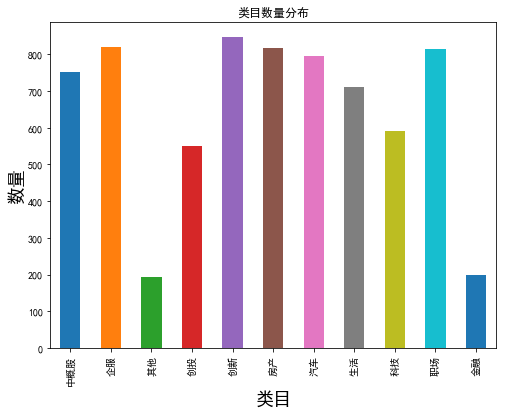

In [3]:
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('qt4agg')  
#指定默认字体  
#matplotlib.rcParams['font.sans-serif'] = ['SimHei']  
#matplotlib.rcParams['font.family']='sans-serif'  
#myfont = matplotlib.font_manager.FontProperties(fname='/root/anaconda3/envs/sklearn/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf')
#解决负号'-'显示为方块的问题  
#matplotlib.rcParams['axes.unicode_minus'] = False  
fig = plt.figure(figsize=(8,6))
plt.title("类目数量分布")
plt.ylabel('数量', fontsize=18)
df.groupby('category').content.count().plot.bar(ylim=0)
plt.xlabel('类目', fontsize=18)
plt.show()

In [4]:
#特征向量

df['category_id'] = df['category'].factorize()[0]

# 几个字典
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [5]:
#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5.]")
    line = rule.sub(' ',line)
    return line

# 停用词
def stopwordslist(filepath):  
    # 
    stopwords = {line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()}
    remove_chars = '[·’!"\#$%&\'()＃！（）*+,-./:;<=>?\@，：?￥★、…．＞【】［］《》？“”‘’\[\\]^_`{|}~]+'
    for x in remove_chars:
        stopwords.add(x)
    stopwords.add('xa0')
    stopwords.add('Xa0')
    stopwords.add('请点')
    return stopwords  

#加载停用词
stopwords = stopwordslist("./data/chineseStopWords.txt")

In [6]:

def startswith_bian_zhe_an(line):
    tezheng = [
        "编者按",
        "文",
        "编辑",
        "本文作者",
        "分析师 ",
        "来源",
        "作者",
        "口述",
        "采访",
        "神译局",
        "策划",
        "视觉",
    ]

    for guize in tezheng:
        if line.startswith(guize):
            return True
        else:
            pass

    return False

def touzhong_shenming(line):
    tezheng = [
    "投中研究院隶属于投中信息",
    "投中信息是一家领先的中国股权投资市场专业服务机构",
    "法律声明",
    "本报告为上海投中信息咨询股份有限公司（以下简称投中信息）制作",
    "本报告包含的所有内容（包括但不限于文本、数据、图片、图标、LOGO等）的所有权归属投中信息",
    "免责声明",
    "关于作者",
    "————",
    "推荐阅读",
    "译者",
    "作者",
    "编辑",
    ]
    for guize in tezheng:
        if line.startswith(guize):
            return True
        else:
            pass
    return False

def handle(text):
    array = text.splitlines()
    result_array = []
    # 前3行
    count = 0
    # 是否是 前6行
    is_qian_6 = False

    # 是否是 后6行
    is_hou_6 = False
    for x in array:
        count +=1
        if count<=6:
            is_qian_6 = True
        else:
            is_qian_6 = False

        if len(array)>=6 and len(array)-count<=6:
            is_hou_6 = True
        else:
            is_hou_6 = False
        x = x.strip()
        if len(x.strip()) ==0 or (is_qian_6 and startswith_bian_zhe_an(x)):
            continue
        elif is_hou_6 and touzhong_shenming(x):
            break
        else:
            result_array.append(x)
    return ''.join(result_array)


In [7]:
#进度条
from tqdm import tqdm
tqdm.pandas()
#分词，并过滤停用词
# df['cut_content'] = df['content'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
#带进度条的形式
df['clean_content'] = df['title'].progress_apply(lambda x: remove_punctuation(handle(x))) + df['content'].progress_apply(lambda x: remove_punctuation(handle(x)))
df['cut_content'] = df['clean_content'].progress_apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df.head()


  0%|          | 0/7088 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.996 seconds.
Prefix dict has been built successfully.
100%|██████████| 7088/7088 [02:24<00:00, 48.94it/s]


,category,content,title,category_id,clean_content,cut_content
0,金融,编者按：本文来自微信公众号“大摩财经”（ID：damofinance），撰文 | 蔚然，36...,奔驰金融刹车：狂飙三年后首次遭遇市场下滑,0,奔驰金融刹车 狂飙三年后首次遭遇市场下滑 大摩财经发现 日前陷入风波的奔驰金融4月1...,奔驰 金融 刹车 狂飙 三年 首次 遭遇 市场 下滑 大摩 财经 发...
1,金融,编者按：本文来自微信公众号“新金融琅琊榜”（ID：finrank），作者：董云峰，36氪经授...,中国金融科技往事,0,中国金融科技往事一代人努力缔造的金融科技传奇 终究还是成为了下一代人习以为常的环境 这是每一...,中国 金融 科技 往事 一代人 努力 缔造 金融 科技 传奇 终究 成为 下一代 习以为...
2,职场,编者按：本文来自微信公众号“璃语职美人”（ID：crystal_words），作者 徐天坤，...,别自欺欺人了，做不到这一点，你永远也找不到适合的工作,1,别自欺欺人了 做不到这一点 你永远也找不到适合的工作 1 ...,自欺欺人 做 不到 一点 永远 找 不到 适合 工作 ...
3,企服,36氪获悉，容器云PaaS服务商「时速云」近日获B+轮战略融资，投资方为琥珀资本。琥珀资本专...,36氪首发 |「时速云」获B+轮战略融资，从云原生向技术中台延伸,2,36氪首发 时速云 获B 轮战略融资 从云原生向技术中台延伸36氪获悉 容器云PaaS服...,36 氪 首发 时速 云 获 B 轮 战略 融资 从云 原生 技术 ...
4,企服,今年5月，综合考量中外资本市场的变化，以及自身发展战略等因素，找钢网主动中止港股上市计划——...,36氪专访 | 找钢网王东：产业电商和消费电商并无本质区别,2,36氪专访 找钢网王东 产业电商和消费电商并无本质区别今年5月 综合考量中外资本市场的变...,36 氪 专访 找 钢网 王东 产业 电商 消费 电商 本质区别 今年 月 ...


经过分词以后我们生成了cut_review字段。在cut_review中每个词语中间都是由空格隔开，接下来我要在cut_review的基础上生成每个分类的词云，我们要在每个分类中罗列前100个高频词。然后我们要画出这些高频词的词云


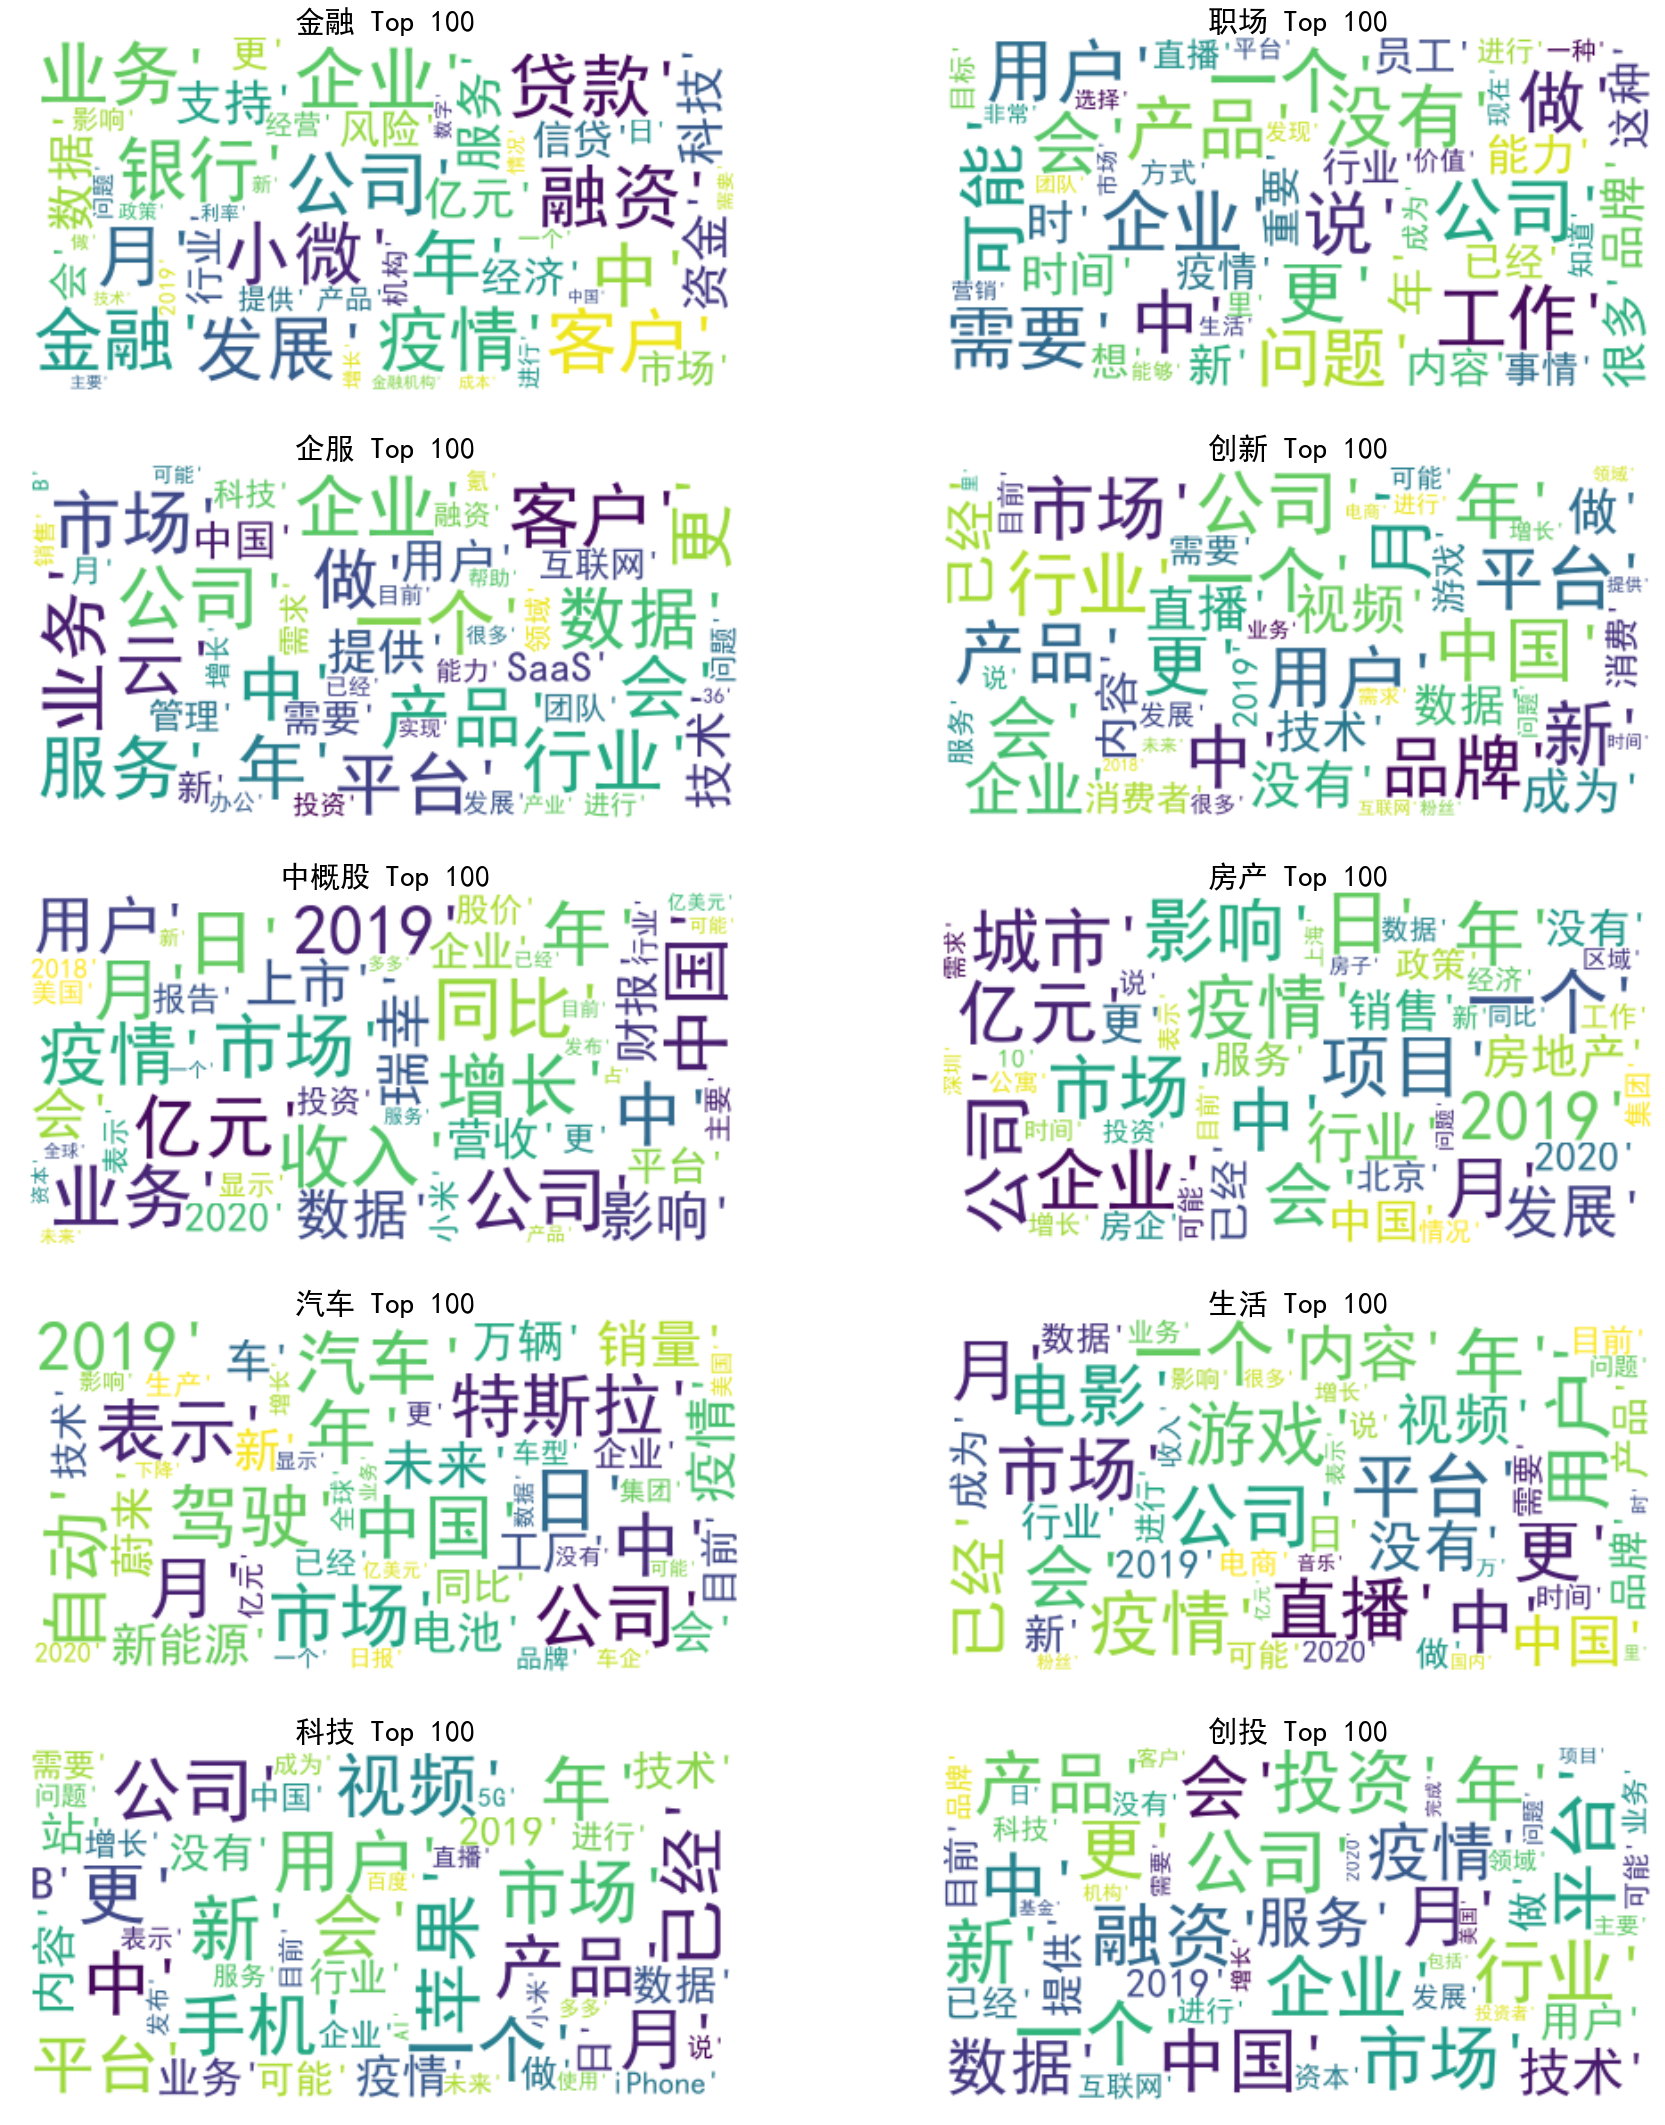

In [8]:
from collections import Counter
from wordcloud import WordCloud
 
# 生成词云    
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          font_path='/root/anaconda3/envs/sklearn/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud


category_desc = dict()
for category in category_id_df.category.values: 
    text = df.loc[df['category']==category, 'cut_content']
    text = (' '.join(map(str,text))).split(' ')
    category_desc[category]=text
    
fig,axes = plt.subplots(5, 2, figsize=(30, 38))
k=0
for i in range(5):
    for j in range(2):
        category = id_to_category[k]
        most100=Counter(category_desc[category]).most_common(100)
        ax = axes[i, j]
        ax.imshow(generate_wordcloud(most100), interpolation="bilinear")
        ax.axis('off')
        ax.set_title("{} Top 100".format(category), fontsize=30)
        k+=1

从上图我们看到，金融中的关键字：
公司、企业、小微、发展，这些都还可以，基本说的通。但是有一些词是不合理的，例如 更、日，等这些词压根没什么意义。不能代表这个分类的主题，所以我们单单用词频来进行向量化,是有问题的。

注：有一些噪音词，通过分析，我们在停用词中过滤掉了："xa0","请点"


### tfidf 进行 特征提取

TF-IDF（term frequency–inverse document frequency）是一种用于信息检索与数据挖掘的常用加权技术。

TF意思是词频(Term Frequency)，IDF意思是逆文本频率指数(Inverse Document Frequency)。TF-IDF是在单词计数的基础上，降低了常用高频词的权重,增加罕见词的权重。因为罕见词更能表达文章的主题思想,比如在一篇文章中出现了“中国”和“卷积神经网络”两个词,那么后者将更能体现文章的主题思想,而前者是常见的高频词,它不能表达文章的主题思想。所以“卷积神经网络”的TF-IDF值要高于“中国”的TF-IDF值。

这里我们会使用sklearn.feature_extraction.text.TfidfVectorizer方法来抽取文本的TF-IDF的特征值。

TfidfVectorizer 的一些参数：

* sublinear_df 设为 True 表示使用频率的对数形式
* min_df 是单词必须存在的最小文档数量
* norm 设为 'l2', 是一种数据标准划处理的方式,可以将数据限制在 一定范围内(-1,1)，以确保我们所有特征向量的欧几里德范数为 1
* ngram_range 设为 (1, 2)，表示考虑 unigrams 和 bigrams。
    -  即，我们除了抽取新闻中的每个词语外,还要抽取每个词相邻的词并组成一个“词语对”。
    -  例如原始词是4个词（词1 词2 词3 词4），得到的结果是： 词1，词2，词3，词4，(词1，词2)，(词2,词3)，(词3，词4)
    -  这样就扩展了我们特征集的数量, 有了丰富的特征集才有可能提高我们分类文本的准确度。

接下来我们要计算cut_content的 TF-IDF的特征值

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
all_tfidf = TfidfVectorizer(sublinear_tf=True,min_df=5,norm='l2', ngram_range=(1, 2))
all_features = all_tfidf.fit_transform(df.cut_content)
labels = df.category_id
print(all_features.shape)
print('-----------------------------')
print(all_features)

(7088, 175409)
-----------------------------
  (0, 83445)	0.04173886369496382
  (0, 160230)	0.04978844066661457
  (0, 167786)	0.0542907157671711
  (0, 105523)	0.038649318689462975
  (0, 166226)	0.05354485035090838
  (0, 116354)	0.03775819053378674
  (0, 13929)	0.041100668398876175
  (0, 69886)	0.05716107379219508
  (0, 139280)	0.0542907157671711
  (0, 163229)	0.05225416433819532
  (0, 116352)	0.055124522363219304
  (0, 103114)	0.055124522363219304
  (0, 116143)	0.04147664208995108
  (0, 166400)	0.04651344828814735
  (0, 42232)	0.0542907157671711
  (0, 154946)	0.05716107379219508
  (0, 121537)	0.048637940896908614
  (0, 164120)	0.05606981431744137
  (0, 40345)	0.05606981431744137
  (0, 71517)	0.055124522363219304
  (0, 4979)	0.055124522363219304
  (0, 97490)	0.055124522363219304
  (0, 157574)	0.055124522363219304
  (0, 25665)	0.04978844066661457
  (0, 25657)	0.05606981431744137
  :	:
  (7087, 165720)	0.016844923890129846
  (7087, 123925)	0.012009321334967142
  (7087, 142956)	0.032712545

我们看到features的维度是(7088, 175409),这里的7088表示我们共有7088条新闻数据，175409表示我们的特征数量这包括全部新闻中的所有词语数+词语对(相邻两个单词的组合)的总数。下面我们要是卡方检验的方法来找出每个分类中关联度最大的两个词语和两个词语对。卡方检验是一种统计学的工具,用来检验数据的拟合度和关联度。这里我们使用sklearn中的chi2方法。

In [10]:
from sklearn.feature_selection import chi2
import numpy as np
 
N = 2
for cat, cat_id in sorted(category_to_id.items()):
    features_chi2 = chi2(all_features, labels == cat_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(all_tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(cat))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# '中概股':
  . Most correlated unigrams:
       . hk
       . 港元
  . Most correlated bigrams:
       . 亿元 同比
       . 制图 36
# '企服':
  . Most correlated unigrams:
       . 暖冬
       . saas
  . Most correlated bigrams:
       . 帮助 企业
       . 暖冬 计划
# '其他':
  . Most correlated unigrams:
       . 证券期货
       . odaily
  . Most correlated bigrams:
       . odaily 星球
       . 星球 日报
# '创投':
  . Most correlated unigrams:
       . 融资
       . 松山湖
  . Most correlated bigrams:
       . 国际 机器人
       . 松山湖 国际
# '创新':
  . Most correlated unigrams:
       . 粉丝
       . 年轻人
  . Most correlated bigrams:
       . 36 英文
       . 英文 krasia
# '房产':
  . Most correlated unigrams:
       . 房地产
       . 房企
  . Most correlated bigrams:
       . 新闻 记者
       . 房地产 市场
# '汽车':
  . Most correlated unigrams:
       . 万辆
       . 汽车
  . Most correlated bigrams:
       . 未来 汽车
       . 汽车 日报
# '生活':
  . Most correlated unigrams:
       . 影视
       . 电影
  . Most correlated bigrams:
       . 电影 市场
       . 电影 行业
# '科技':
 


它们都有道理，难道不是吗？

我们可以看到经过卡方(chi2)检验后，找出了每个分类中关联度最强的两个词和两个词语对。这些词和词语对能很好的反映出分类的主题。

所以，我们以上的ididf抽取的特征，是没有问题的。可以使用其作为特征向量。



多类别分类器：特征和设计

为了训练监督分类器，我们首先将「36kr新闻」转化为数字向量。我们研究了向量表示， TF-IDF 加权向量。
有了这个向量表达的文本后，我们可以训练监督式分类器来训练看不到的「36kr新闻」并预测它们的「类别」。


在完成上述数据转换之后，现在我们拥有所有的特征，是时候训练分类器了。我们可以使用很多算法来解决这类问题。

# 3、真正开始数据训练

朴素贝叶斯分类器：最适合用于基于词频的高维数据分类器，最典型的应用如垃圾邮件分类器等,准确率可以高达95%以上。现在，我们就用利用sklean进行朴素贝叶斯分类器 训练：MultinomialNB
用贝叶斯来一次尝试


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
 
X_train, X_test, y_train, y_test = train_test_split(df['cut_content'], df['category_id'], test_size=0.25)
# 注意这个（fit_transform后的）tfidf 非常有用，在预测方法中要用，如果训练和预测不在一段代码中，应该持久化，以便后期预测时从文件中加载
tfidf = TfidfVectorizer(sublinear_tf=True,min_df=5,norm='l2', ngram_range=(1, 2))
X_train = tfidf.fit_transform(X_train)

clf = MultinomialNB().fit(X_train, y_train)

In [12]:
def myPredict(sec):
        
    format_sec=" ".join([w for w in list(jb.cut(remove_punctuation(handle(sec)))) if w not in stopwords])
    # tfidf 是训练中用到的，不能自行初始化                     
    pred_cat_id=clf.predict(tfidf.transform([format_sec]))
    #print(pred_cat_id)
    print(id_to_category[pred_cat_id[0]])

In [13]:
# 中概股
a="""
去年年底，微盟曾密集回购45次。
5月7日，电商SaaS企业微盟集团(02013.HK)发布早间公告称，5月6日，公司及其全资附属公司Weimob Investment Limited、经办人三方已订立债券认购协议，微盟为担保人，Weimob Investment Limited为债券发行人，经办人为认购人，包括瑞信、摩根士丹利、中金公司，债券拟在香港联交所上市。

据悉，该债券为本金总额1.5亿美元于2025年到期的美元计值1.50%有担保可换股债券。初步换股价为每股6.72港元，较5月6日收市价5.95港元溢价约12.94%。

微盟成立于2013年，2019年在港交所主板上市，是一家SaaS产品和精准营销服务提供商，腾讯是其第二大股东和重要的合作伙伴。

若按照初步换股价6.72港元悉数兑换债券，可兑换最多1.73亿股新股，占公司现有已发行股本约7.73%，占经根据债券配发及发行新股扩大后公司已发行股本约7.18%。兑换后，孙涛勇、方桐舒及游凤椿作为一致行动人占公司现有已发行股本下降1.03个百分点至13.32%，腾讯仍为其第二大股东，占公司现有已发行股本下降0.58个百分点至7.5%。

这是微盟上市以来第二次公开筹资。

微盟表示，过去12个月内，公司仅于2019年7月26日通过新股配售筹资11.57亿港元，截至3月31日，约5920万港元已按计划动用，公司拟于2021年12月31日前悉数动用剩余款项。

而本次筹资净额约为1.466亿美元（约合11.36亿港元），将被用于提升综合研发实力(主要包括购置硬件设备及支付雇员薪酬)、升级营销系统、建立产业基金、补充营运资金及一般公司用途。

值得注意的是，去年10-12月间，微盟密集回购达45次，斥资约1亿港元，累计购回约2799万股，占已发行股份数约1.39%。

另据微盟2019年财报，去年公司营收同比上涨66.1%至14.36亿元，实现转亏为盈，净利润为3.31亿元，去年亏损10.94亿元。

财报发布当天，微盟股价止跌收涨近6%，之后股价走势一路向上。此次筹资消息公布后，今日港股开盘，微盟微跌，截至发稿，跌3.53%至5.74港元。

原创文章，作者：宋子乔。转载或内容合作请点击 转载说明 ，违规转载法律必究。

寻求报道，请 点击这里 。

本文图片来自：Pexels 正版图库
"""
myPredict(a)

中概股


In [14]:
# 科技
b = """
微软 Surface 全家桶大更新：Surface Book 3 来了，还有新降噪耳机

今天，Surface 家族已经来到了第 8 个年头，Surface 也继续推陈出新
编者按：本文来自“爱范儿”，作者：雷健恒，36氪经授权发布

2012 年 6 月 19 日，微软发布了第一款 Surface 产品：Surface RT。作为微软试水 PC 硬件的第一款产品，一方面因为其笔记本平板二合一的新形态打破了当时 PC 市场同质化严重的尴尬局面而受到赞扬，另一方面则因为产品体验无论是在 PC 端还是平板端都没有达到用户预期而备受诟病。

在当时不少媒体猜测，Surface 很可能会是一次短暂的尝试，并将会以 Surface RT 平淡的表现而草草结束。

但后来，Surface 不但没有成为过去，产品家族还空前繁荣。除了数款 PC 以及二合一系列产品以外，Surface 家族还衍生出了双屏电脑 Surface Neo、双屏手机 Surface Duo 以及真无线耳机 Surface Earbuds 等产品。

今天，Surface 家族已经来到了第 8 个年头，Surface 也继续推陈出新。这次他为我们更新的四款产品，包括：Surface Go 2、Surface Book 3、Surface Headphones 2 以及 Surface Dock 2



Surface Go 2：屏幕大了些许，依旧便携与实惠
此前在接受《Wired》采访时，微软 Surface 之父 Panos Panay 表示，Surface Go 是一次对 Pro 系列技术下放的尝试。

确实，你在 Surface Go 上能看到大哥 Pro 上的影子，包括二合一的产品形态、同样的支架铰链，甚至是相同的铝镁合金外壳，以及是相同的 Alcantara 材质键盘。两者在外观上最大的不同，就是尺寸。



微软表示，最早打造 Surface Go，是旨在为 Surface 系列增加一款更实惠、更便携的二合一设备。

而如今，Surface Go 2 在延续了「随时可 Go」的特性， 保持上一代轻薄设计的同时，通过窄边框设计，塞进了一块更大的 10.5 英寸触控显示屏（上一代为 10 英寸），屏幕分辨率也从 1800×1200 增加到 1920×1280，同时还提供了更长的电池续航。



在硬件配置方面，Surface Go 2 分为 LTE 版本和 Wi-Fi 版本。其中 LTE 版本搭载的是英特尔 Core m3-8100Y 处理器，配备 8GB 内存和 128GB 存储空间。WiFi 版本搭载的是英特尔 Pentium 4425Y 处理器，配备 4GB 内存和 64GB 存储空间。



另外，Surface Go 2 也跟上了时代的步伐，支持 Wi-Fi 6 网络连接。至于接口方面，Surface Go 2 相较于前代并没有发生变化，依然只配备一个 USB-C 接口、一个 3.5mm 耳机接口以及一 个 Surface Connector 磁吸式充电接口。

最后， Surface Go 2 除了延续上一代的「轻便」以外，也延续上一代的「实惠」，新机起步价依旧不超 3 千元，为 2988 元。

Surface Book 3：性能再进一步
紧接着轻量级选手 Surface Go 2 之后登场的则是家族中的的全能型选手 Surface Book 3。Surface 家族中不同系列有着各自的侧重点，Surface Go 侧重便携、Surface Book 3 则侧重专业性能。

初代 Surfac Book 诞生的初衷，就是满足那群对二合一产品情有独钟，又需要强劲的性能配置去运行 Autodesk、Adobe 等专业软件的用户。作为性能最强劲的 Surface 家族二合一产品，虽然这次更新在外观上改变不大，但 Surface Book 3 这次在性能上则更进了一步，让加班来得更从容一些。



Surface Book 3 搭载英特尔第十代酷睿处理器，包括酷睿 i5 1035G7 和 i7 1065G7，同样支持 Wi-Fi 6。图像性能方面，部分高配版本的 Surface Book 3 搭载英伟达 GrForce GTX 1650 或 GeForce GTX 1660 Ti 独立显卡。



而对于计算能力和 IO 性能有较高的要求开发者等用户，Surface Book 3 的内存最高也可以选至 32GB。微软表示，Surface Book 3 相比起前代，性能提升 50%，电池续航时间最长可达 17.5 小时。

更强的性能除了意味着更从容地应对各种专业工作以外，Surface Book 3 也可以每秒 60 帧的速度畅玩 PC 版 Xbox Game Pass 游戏库中 1080p 游戏。



Surface Book 3 继续提供 13 英寸与 15 英寸两种版本，但无论你选哪种版本，Surface Book 3 均搭载支持触控的 High-DPI PixelSense 屏幕。

更全面的能力当然意味着更高昂的价格，Surface Book 3 起步价为 12888 元。

Surface Headphones 2：降噪更强也更持久了
从 2018 年开始，Surface 系列开始覆盖声学产品，发布了第一代 Surface Headphones。作为首款 Surface 耳机，其出色的降噪效果和无线体验赢得了不少称赞，但其依然存在着续航能力不佳、高频表现一般等遗憾。这些做得好与做得不好的地方，无疑都让用户更期待它的迭代产品。

而在两年之后，Surface Headphones 2 来了。



Surface Headphones 2 采用了全新的设计，耳罩可以进行 180 度的翻转，让用户把耳机挂在脖子上时更加舒适。

Surface Headphones 2 的主动降噪能力也得到了加强，除了可以通过贴耳式拨盘进行 13 级的降噪力度调节以外，Surface Headphones 2 还可以实现人声过滤或者是人声增强的效果。这样，你想听得到的声音即便不用摘下耳机也能听得一清二楚，不想听到的声音，Surface Headphones 2 都能够帮你隔绝于耳外。



之前被诟病的续航问题在 Surface Headphones 2 上也得到增强了，据微软介绍，Surface Headphones 2 在充满电后，在通过蓝牙连接以及开启主动降噪功能下，能提供 20 小时的续航时间。

Surface Headphones 2 这次提供两种配色，分别是钛白灰和典雅黑，售价为 1998 元。

值得一提的是，在去年发布的真无线耳机 Surface Earbuds 如今也一同上市了。相比起市场上的众多真无线耳机，Surface Earbuds 的辨识度相当高，设计也十分前卫。



另外，Surface Earbuds 的产品力也足够强，除了分体式耳机常见的手势操作以外，Surface Earbuds 也与 Microsoft 365 进行深度结合，让用户通过耳机使用 Word、Outlook 以及 PowerPoint 中使用听写功能。

Surface Earbuds 售价为 1588 元。

Surface Dock 2：好用，也好贵
除了电脑和耳机以外，微软这次还带来了 Surface 电脑的拓展坞产品 Surface Dock 2。在外形和体积上，Surface Dock 2 相较于前代变化不大，主要是背面的 Mini DP 接口以及正面的 USB-A 接口都换成了 USB-C 接口。



另外，Surface Dock 2 的电源也获得了升级，从此前的 95W 升级到最大支持 200W 的功率，给设备充电的速度得到了大幅的提升。



Surface Dock 2 配置齐全，功能也足够强大，唯一的缺点，应该就是贵了吧，售价为 2288 元。

Surface 是展示软件产品的最重要窗口
正如开头所说，来到第八个年头的 Surface 已经从最初只有两款产品（Pro 和 RT）的试水先锋，发展成了一个庞大的产品家族。

微软在这八年里，通过不断地推陈、不断地出新，把人群从入门的学生覆盖到专业人士，也试图通过更多不同的品类将 Surface 推向不同的方向。



从 Gartner 的统计数据上看，去年第四季度，Surface 的出货量在全球排名第七，在美国市场排名第五。对于微软而言，Surface 俨然也已经成为驱动业务增长的一个重要引擎。

然而对于微软来说，更重要的其实并不是这些硬件能给公司带来多少利润，而是完全由自己主导的软硬结合体验，以及这所带来的大批忠实用户。



就正如 Surface 之父 Panos Panay 在去年接受媒体采访时，当被问到 Surface 之于微软的意义时回答的一样：

在微软内部，我们赋予 Surface 的定义是微软所有精华的集大成者和最佳的表现窗口，它是一个集合了微软所有优点的产品。

不管微软做什么，云也好，操作系统也好，应用也好，我们都希望在各个领域的优势、能力都能够完美体现在 Surface 的产品上。

本文经授权发布，不代表36氪立场。如若转载请联系原作者
"""
myPredict(b)


创新


不是太寒酸！

## 模型选择

我们现在准备尝试不同的机器学习模型，评估它们的准确性并找出潜在问题的根源。

我们将对以下四种模型进行基准测试：
* Logistic Regression(逻辑回归)
* (Multinomial) Naive Bayes(多项式朴素贝叶斯)
* Linear Support Vector Machine(线性支持向量机)
* Random Forest(随机森林)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import time
from sklearn.model_selection import cross_val_score
 
 
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0), # 这个时间比较长，
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name,'开始训练')
    start = time.process_time() #记下开始时刻
    accuracies = cross_val_score(model, all_features, labels, scoring='accuracy', cv=CV)
    print(model_name,'训练完成，用时', time.process_time()-start)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier 开始训练
RandomForestClassifier 训练完成，用时 15.277296451999973
LinearSVC 开始训练
LinearSVC 训练完成，用时 28.25062687100001
MultinomialNB 开始训练
MultinomialNB 训练完成，用时 1.4275959410000496
LogisticRegression 开始训练
LogisticRegression 训练完成，用时 4376.484987176


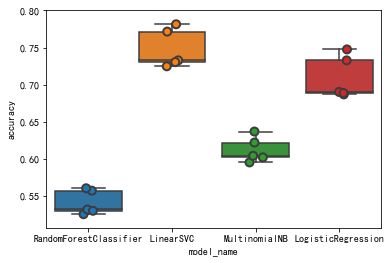

In [16]:
import seaborn as sns
 
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

从可以箱体图上可以看出随机森林分类器的准确率是最低的，因为随机森林属于集成分类器(有若干个子分类器组合而成)，一般来说集成分类器不适合处理高维数据(如文本数据),因为文本数据有太多的特征值,使得集成分类器难以应付,另外三个分类器的平均准确率都在60%以上。其中线性支持向量机的准确率最高。

In [17]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.748160
LogisticRegression        0.709221
MultinomialNB             0.612018
RandomForestClassifier    0.540915
Name: accuracy, dtype: float64

我们看到线性支持向量机的平均准确率达到了74.8%，其次是逻辑回归和朴素贝叶斯。

下面我们就针对平均准确率最高的LinearSVC模型，我们将查看混淆矩阵，并显示预测标签和实际标签之间的差异。

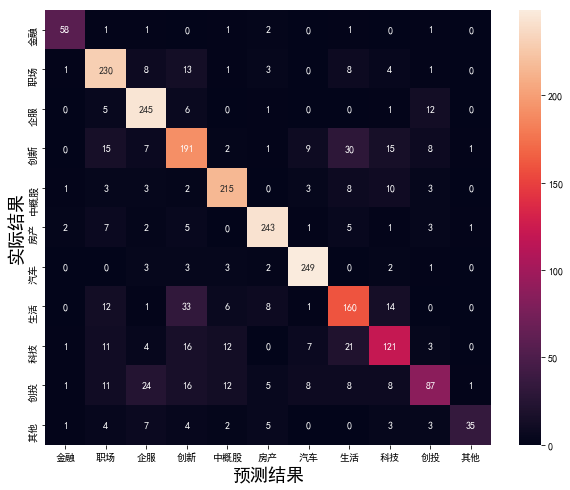

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
 
#训练模型
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(all_features, labels, df.index, 
                                                                                 test_size=0.33, stratify=labels, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
 
 
#生成混淆矩阵
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('实际结果',fontsize=18)
plt.xlabel('预测结果',fontsize=18)
plt.show()

混淆矩阵的主对角线表示预测正确的数量,除主对角线外其余都是预测错误的数量.从上面的混淆矩阵可以看出"金融"和“其他”类预测最准确。“生活”和“创新”预测的错误数量教多。

 多分类模型一般不使用准确率(accuracy)来评估模型的质量,因为accuracy不能反应出每一个分类的准确性,因为当训练数据不平衡(有的类数据很多,有的类数据很少)时，accuracy不能反映出模型的实际预测精度,这时候我们就需要借助于F1分数、ROC等指标来评估模型。

下面我们将查看各个类的F1分数.

In [19]:
from sklearn.metrics import classification_report
 
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=category_id_df['category'].values))

accuracy 0.7837606837606838
              precision    recall  f1-score   support

          金融       0.89      0.89      0.89        65
          职场       0.77      0.86      0.81       269
          企服       0.80      0.91      0.85       270
          创新       0.66      0.68      0.67       279
         中概股       0.85      0.87      0.86       248
          房产       0.90      0.90      0.90       270
          汽车       0.90      0.95      0.92       263
          生活       0.66      0.68      0.67       235
          科技       0.68      0.62      0.65       196
          创投       0.71      0.48      0.57       181
          其他       0.92      0.55      0.69        64

    accuracy                           0.78      2340
   macro avg       0.79      0.76      0.77      2340
weighted avg       0.78      0.78      0.78      2340



从以上F1分数上看,"骑车"类的F1分数最大 ，其次是“房产”，“创投”类F1分数最差只有57%，究其原因可能是因为“创投”这个类别不是很清晰，跟其他分类有交叉导致的。

下面我们来查看一些预测失误的例子,希望大家能从中发现一些奥秘,来改善我们的分类器。

In [20]:
from IPython.display import display
 
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("{} 预测为 {} : {} 例.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'clean_content']])
            print('')

创新 预测为 职场 : 15 例.


,category,clean_content
3924,创新,实体零售的危险苗头这个危险苗头的意思 是说经过疫情考验之后的零售企业 普遍都有线上订单供不应...
308,创新,没有人能批评罗永浩 但谁都可以批评吴晓波 书航10 月 7 日发于北京 10月6日 罗永浩评...
2742,创新,从濒临破产到世界最大的玩具制造商 乐高做了什么 21世纪初 面对电子游戏和互联网日益激烈的竞...
310,创新,不做老师做网红 卖课爆赚8500万 薛兆丰怎么做到的 薛兆丰是谁 他是在知识付费平台 得到...
2106,创新,是大洗牌 更是窗口期 零售企业在疫情期的转型升级疫情仿佛一道直接送达企业的战书 很快 一场场...
494,创新,微商是怎样通过抖音年入5000万的 抖音已经事实上成为淘宝店主 线下商家以及传统微商最重要的...
1028,创新,2020年 属于AI的未来简史将会如何书写 尤瓦尔 赫拉利 Yuval Noah Harar...
980,创新,李佳琦 完美日记的微信私域流量运营今年李佳琦很火 完美日记很火 私域流量也很火 一个是时...
1032,创新,狂撒1000万红包 收割1亿用户 当下能匹敌拼多多的裂变玩家 只有它们了大家好 我是你们的小...
1163,创新,AI面试催生韩国新型补习班 200元一小时 面对摄像头练习用眼睛微笑从公职考试 外语培训 练...



房产 预测为 职场 : 7 例.


,category,clean_content
5998,房产,蛋壳公寓等多方联合启动 职为2020大学毕业生成长计划 今年全国普通高校毕业生达874万人 ...
1633,房产,守望相助战新冠 系列课程七 特殊时期 销售团队的管理探讨随着疫情的深入发展 整个国民经济...
2561,房产,超级观点 危机之下 如何降低能耗度过调整期 带着观点看商业 超级观点 来自新商业践行者...
5185,房产,房产经纪能否成为终身事业 听听BBking陈铭怎么说4月13日 德佑邀请知名辩手陈铭和德佑品...
3370,房产,同样是董事长 为什么人人都爱陈启宗的致股东函三四月份是年报季 A股和港股的上市公司 正集中发...
1987,房产,直播培训师 线下品牌如何打造导购 网红 延后的复工时间 骤减的客流 工作人员的薪资负担 种种...
2491,房产,二更首席创意长梁景林 疫情下的幸福经济学阿里创新业务事业群智能营销平台UMIC课堂 同行...



生活 预测为 职场 : 12 例.


,category,clean_content
3179,生活,新冠疫情蔓延之际 千万不要盲目锻炼 图片作者 Maria Chimishkyan 昨天下...
7001,生活,打捞更多 海底捞 资本和餐饮在加速 和解 超级观点 带着观点看商业 超级观点 来自新...
6878,生活,说自己在短视频里亏了1000万的那个人 我们和他聊了聊今天 我是如何在短视频里亏掉1000...
3658,生活,让人崩溃的会员 服务 如果让会员服务占据了用户太多的时间和精力 这种 服务 就变成了负担 ...
5891,生活,个体咖啡店失败率为何居高不下 姜涛 中赫时尚咖啡高级讲师 Cohim咖啡项目运营管理 ...
6527,生活,直播的2.0时代 从 大水漫灌 到 流量入渠 导语 对于已经熟透了的中国移动互联网来说 没...
4983,生活,三个东北MCN老板的主播养成记 东北天冷 寒冬数九 就得喝酒暖身 这天 罗凤魁搞了点狍子肉 ...
4325,生活,被网赌毁掉的年轻人 本想兼职赚钱 结果倾家荡产 网络兼职刷单 足不出户 轻松赚钱 疫情期...
5996,生活,拆解全球性 健康码 伦理难题 算法治理的 三道坎 新冠疫情的全球...
5334,生活,重新定义社区营销 五大维度和七寸命门 我们需要从渠道角色 营销目标 社区媒体等多个维度 ...



科技 预测为 职场 : 11 例.


,category,clean_content
5538,科技,B站为什么不是中国油管 在很多中国 老干部 心中 B站只是小学生们看二次元动画片的小众视频...
4525,科技,美国国会限制股票回购 给贪婪的CEO们带去错误的利益 翻译 小彩 作为数万亿美元财政刺激...
4705,科技,2020 市场部求生指南 今天的内容关于营销行业的迭代 涉及拼多多 携程 微信广告等多个品...
5095,科技,清华大学吴国盛 这一学科将影响中国人对科学的理解 却只有几所大学开设 近年来 针对现代社会的...
6563,科技,爱泼斯坦的丑闻 为什么成为了美国学术界的 公关危机 科研 利益 丑闻 这三样概念 因为去年...
7059,科技,在B站做市场真是太幸福了 手艺不好学 B站又刷屏了 流下了羡慕嫉妒恨的泪水 在B站做市场真是...
6285,科技,在疫情严重的美国 乘务员和飞行员为何要继续工作 推荐阅读 削减运力 裁员 飞机提前退役...
5861,科技,MIT实验室研发出一种新设备 可以解析梦境 图片来源 MIT 纵观我们这一生 大约三分之...
6160,科技,黑白视频号 黄金和韭菜齐飞 视频号已经挤满了人 挖黄金的 和想割韭菜的 200...
5646,科技,教培机构冲上牌桌 OMO却不是张万能牌 超级观点 带着观点看商业 超级观点 来自新商业践...



创投 预测为 职场 : 11 例.


,category,clean_content
6042,创投,为什么说2020年是创业的最佳时机 图片来源 Ariane Frida Sofie 2...
4681,创投,抖音 快手 淘宝 腾讯四大直播平台的流量逻辑是什么 超级观点 带着观点看商业 超级观点 来...
5199,创投,募资道路上的 前进 和 拐弯 2020年开年 一级市场上的GP们用 冰火两重天 来形容应该不...
5964,创投,吴晓波 因为疫情 我们正在 孪生 一个云上的中国十多年前 我写了一本关于1978年后的中国企...
5840,创投,重新审视瑞幸 微信 Airbnb 快速增长的边界在哪瑞幸曾是一个传奇 开店数量 上市时间 营...
5535,创投,对话福佑卡车单丹丹 世上最难走的路就是捷径 题图 福佑卡车创始人兼CEO单丹丹 关注到单丹...
5148,创投,尼尔森 后疫情时代 新的市场需求或将迎来消费反弹通常来说 消费者的行为习惯会随着时间而慢慢发...
5856,创投,对于巴菲特的沉默 每个人都需冷静下来回顾一下巴菲特在2008 2009年期间的所作所为 并详...
6872,创投,喻国明 从资讯到关系 未来媒体如何构建影响力 近年来 人工智能 物联网 5G等新技术革命使包...
5430,创投,产品观察 以对话式互动学习撬动转化 扇贝编程瞄准职教市场成人编程教育是职业教育行业最火热...



职场 预测为 企服 : 8 例.


,category,clean_content
2152,职场,非常时期 聊聊办公协作产品 开工是不可能开工的 这阵子不可能开工的 正月初十的时候 一个...
3155,职场,为企业定制即时用户体验调研 UserTesting 获1000万美元C轮融资 图片来源 U...
2968,职场,埋点还是埋雷 5000字教你如何结构化的埋点 成功避雷在接触过上百家头部App客户中 诊断和...
3269,职场,痴迷客户 才是任正非乔布斯贝佐斯的第一理念内容来源 本文将分析亚马逊创始人 CEO 杰夫 贝...
2687,职场,通过研究网站的流量数据 我们在美股赚了一笔大家好 我是增长工程师yolo 也是增长黑盒的合伙...
4978,职场,货代做电商有哪些坑 这是我见过最 干货 的总结 接到航运界做直播的邀请 我感觉他们有些 居心...
2630,职场,你拥有帮别人赚钱的能力吗 内容来源 2019年11月23日 上海交通大学海外教育学院主办 ...
3695,职场,传统媒体如何用科技助力营销 三招教你贴近用户美国出版与传媒巨头Meredith旗下拥有 美好...



创新 预测为 企服 : 7 例.


,category,clean_content
170,创新,尼日利亚 货车帮 获3000万美元A轮投资 正迎来政策春天 拉各斯拥堵的交通 图片来源 Tr...
2124,创新,多点Dmall总裁张峰 零售突围 全面数字化的高扩展和快迭代 WISE x 新效率时代峰...
469,创新,探秘细分消费品市场 与时间共舞 最终境界是 控货输出 部分细分品类的消费品企业 正...
2183,创新,最前线 任正非 WeLink迎来战略机会窗口 要成为中国最大企业办公平台疫情带动了远程会...
2306,创新,疫情刺激下 灵活用工平台会成为下一个万亿级风口么 新冠肺炎疫情爆发至今 也并非全是萧条声 很...
296,创新,如何成就百亿市值新消费企业 创业者必须知道的 流量 产品 渠道 方法论 品牌是个永恒的话...
1050,创新,教育2B是门好生意吗 本文来自微信公众号 凯力说 ID carryyyyy 2018 作...



创投 预测为 企服 : 24 例.


,category,clean_content
6066,创投,前美团云总经理成立 大禹智芯 对标 Pensando 构建超高速网络解决方案5G低延时 大...
5075,创投,亏损下增长成疑 云服务独角兽青云科技 凭什么让市场 认账 数据支持 勾股大数据 过去几个...
4869,创投,专注会议室效率提高 枫芒科技 为企业提供智慧社区物联网管理系统服务 开会了 哪个会议...
6138,创投,信息安全的春天来了 一年涌入29亿资金 业务量增长3倍 最近的信...
4442,创投,企业培训在国内是一桩怎样的生意 上 在中国 根据 培训 杂志数据 从人均培训预算值来看 ...
5816,创投,从传统行业大客户入手 数聚股份 开发数据治理平台解决 信息孤岛 Gartner2012 2...
5985,创投,从工业软件转型工业互联网平台 朗坤智慧 已接入35万台设备随着物联网 大数据等技术的发展 ...
6211,创投,提供一站式资产配置解决方案 川谷金融 将业务拓展至家办与独立理财师 2020新科技创业 ...
5677,创投,36氪首发 从陌生人社交娱乐切入 非洲版陌陌 Mochat 获数百万人民币种子轮融资36...
6148,创投,朱啸虎 人口红利终会消失 技术红利才是长青基石近期 金沙江创投主管合伙人朱啸虎先生做客中欧创...



其他 预测为 企服 : 7 例.


,category,clean_content
4700,其他,森亿智能张少典 你可能被人工智能辅助诊疗救过命 经过几年的发展 中国的医疗人工智能...
6065,其他,云启报告 垂直行业企业服务投资 路在何方 疫情之后 企业服务在不断升温 赋能传统行业...
4244,其他,创世伙伴资本周炜 用技术实现倍增效应 To B重在增加价值从2015年企服投资元年开始 以企...
4658,其他,互联网 助力企业拓市场 青岛启动 我为企业找订单 活动4月10日上午 由市民营经济发展局...
5485,其他,产业中台 跨境电商中小卖家的PlanB 超级观点 带着观点看商业 超级观点 来自新商业...
4116,其他,全流程智能化 工业APP 智能协作机器人 成都企业展现智能生产创造力十几个工段的全流程智能...
5721,其他,乌云的金边 疫情催生的新机会 GGV投资笔记第二十九期 ...



职场 预测为 创新 : 13 例.


,category,clean_content
3761,职场,154 万 AI 开发者用数据告诉你 中国 AI 如何才能弯道超车 数据 杨阳 刘学涛 ...
2305,职场,功能饮料江湖鏖战 健力宝含恨没落 东鹏特饮欲执牛耳 曾经号称 功能饮料黑马 的脉动如今卖不动...
6204,职场,多金年轻高学历 有关AI人才的6个真相从三年前年薪 25 万只是白菜价 到去年华为以年薪最高...
4151,职场,获风投近百亿美金注资的美国d2c品牌浪潮是如何爆发的 DTC 的诞生近年来给美国的零售业带...
2245,职场,玩个宝可梦就成星爸爸忠粉 游戏化场景正在助力营销你是否想过 可能我们身处的世界都只是一个庞大...
5357,职场,增量时代 是时候和存量思维说再见了我们先来看三个小故事 1 英特尔的故事 年轻的一代可能并...
2531,职场,如何正确地与Z时代沟通 银河系搭车客指南 的作者 英国科幻作家道格拉斯 亚当斯曾经提出过一...
5038,职场,9 岁视频主播年赚 1.8 亿 但儿童网红相关的争议从未停息 广告学中有一个 3B ...
3132,职场,5个多小时长镜头 苹果为何总能拍出电影级广告 广告的黄金时长是多少 5秒 15秒 30秒还是...
3524,职场,产品战略五重奏 下 本篇接上篇 产品战略五重奏 上 继续探讨产品战略的突破点选择 逐层...



企服 预测为 创新 : 6 例.


,category,clean_content
5166,企服,周一见 万亿规模的 银发经济 是大生意还是大冒险 8分钟发布会 01.连接在此正发生 4月...
151,企服,晶泰科技赖力鹏 AI到底能在新药研发中做什么本文由 华兴有个 Alpha ID hxalp...
386,企服,36氪研究 2020年中国新经济趋势洞察报告近十年来 中国股权投资市场蓬勃发展 保持18...
2109,企服,丁香园创始人兼董事长李天天 2020年互联网医疗会大爆发吗 WISE x 新效率时代峰会3月...
1789,企服,虚拟的云xx经济越热闹 现实的自己就越孤独 若是评选2020年度中国汉字 云 或许有入选的...
666,企服,视频相亲火了 背后有哪些技术难点 当直播类产品经过大战趋于冷静之后 视频相亲交友app 伊...



生活 预测为 创新 : 33 例.


,category,clean_content
6473,生活,红牛饮料的镜像与死敌 启丰食品先后获李嘉诚与博裕资本投资4月 泰国天丝旗下红牛维生素风味饮料...
3501,生活,给中国女工寄台缝纫机 她能还你一条拯救世界的生产线 过去的56天 缝纫女工尹妹朝八晚十缝制防...
6881,生活,快递柜收费 难救 穷疯 的丰巢 作者 杨建钊 编辑 刀疤姐 丰巢快递柜 再一次成...
3899,生活,日本也要开始 防沉迷 了 3月18日 日本香川县议会正式通过了 网络及游戏成瘾对策条例 ...
4414,生活,做电商难 做 C2M 电商更难 责编 蛋总 移动互联网已进入了全面的 存量竞争 时代 电商...
6126,生活,世界读书日 2亿人一年花109亿小时在夜里 听书 互联网时代 人们已经习惯了使用手机 I...
3597,生活,同程艺龙2019年财报发布 高增长背后的ITA战略财报显示 按合并基准 同程艺龙全年收入同比...
4561,生活,明知 动森 是一场游戏 为什么那么多人 动真情 过去一个月 你的朋友圈里...
3689,生活,寒冬来了 不 播客的黄金期或许才刚刚开始编译 郭倩 在媒体行业 每当一项新技术展现出良好的发...
5448,生活,日系女企业家 林小宅养成背后 软萌系的生意要怎么做 林小宅一出场 练习生们就炸开了锅 ...



科技 预测为 创新 : 16 例.


,category,clean_content
5230,科技,一款 被动式 情绪追踪应用 能识别哪些网站让你 压力山大 图片来源 Mis 官网截图...
4456,科技,华为发布会引入VR直播 苹果收购初创企业 科技巨头攻克VR痛点进行时昨晚 4月8日 19时3...
5539,科技,争夺时长 互联网的秘密无限战 按照既定的计划 微信视频号新一批灰度测试也已经开始 有业...
5351,科技,科学家认为 这种海虫未来会拯救全球老年人 探测船出发 这里是阿拉巴马州的达菲岛 十二月 周...
6245,科技,借力新电商 陕西平利 多多农园 王秀梅带动51户脱贫 4月20日 习近平总书记正在平利县考...
6100,科技,疫情过后的教育综合体 还能保持发展势头吗 导语 随着社会不断快速发展 80 90后新生代家...
5862,科技,六十天后迎来 大考 孩子们和在线教育行业的答卷会是啥样 在疫情期间 延期开学 的通知不...
5227,科技,创造下个 完美日记 天猫模式批量制造大牌 强化 超级单品 超级新品 特色商品 的三种能力 ...
6573,科技,拼多多为什么能成功 前几日 拼多多发布了2019全年业绩报告 报告显示 拼多多2019年实现...
5851,科技,拼多多发布农产品上行发展报告 两台四网 战略助力农业农村 新基建 4月21日 在2019年...



创投 预测为 创新 : 16 例.


,category,clean_content
5254,创投,三只松鼠2020新财报 利润下滑都是疫情的锅 图源 刘旷 在某个午后 甲方的 五彩斑斓黑 ...
5914,创投,万亿工业大麻市场 刀尖上起舞 资本中新生 剥离出工业大麻中 大麻 二字携带的主观恐惧 ...
6606,创投,2019变现元年启示录 PC落幕 展示 效果 当立 在此前的分享中 Mr.QM曾说2019...
5661,创投,李志刚 养老行业迎来黄金时代 将诞生千亿级公司2020年 60后逐渐步入退休年龄 苦熬着的养...
6476,创投,印度折叠 中国老板抢夺印度老铁熟悉的抖音神曲下 小姐姐们跳着跳舞 少年翻着高难度的跟头 狗狗...
6053,创投,用飞机放卫星的新技术 价格只要马斯克家的2折说到放卫星的科技公司 我们很容易想到马斯克的 S...
6556,创投,我试了三次 靠3个模型 终于把燕窝做成像奶茶一样的产品 偶像蔡徐坤 有一次在综艺节目里自带保...
5805,创投,创新 下沉与追赶 我们和新中式茶饮品牌 沪上阿姨 聊了聊六年发展史 新中式茶饮品牌在过去两年...
4766,创投,美团蚕食携程2003年12月9日 梁建章带着4岁的携程登陆纳斯达克 上市首日其股价就几乎翻番...
5002,创投,手机回收标准难统一 壹站收 要用机器人全自助回收破局近年来 二手智能手机市场不断增长 ID...



生活 预测为 中概股 : 6 例.


,category,clean_content
6444,生活,快递业 流量地图 出炉 收件人地址 显示内需走强外需减弱近日 国家邮政局市场监管司副司长边...
6712,生活,腾讯接手阅文 网络小说要全免费了 2020年4月27日 阅文集团宣布管理团队调整 现任联席C...
6482,生活,6年亏掉60亿 市值缩水95 这只跟团游第一股比瑞幸还惨导语 中概股当中 比瑞幸咖啡还惨的...
5565,生活,畅游成功私有化 但搜狐的三张牌仍不好打历时三年 张朝阳私有化畅游的愿望终于达成 本周 搜狐...
3801,生活,智美宕机 一年巨亏4.55亿的背后 亏损4.55亿人民币 这是曾经叱咤全国的 马拉松第一股 ...
5681,生活,疫情冲击下 猫眼娱乐盈利背后的焦虑在连续亏损六年后 猫眼娱乐终于在2019年迎来了首次年度盈...



科技 预测为 中概股 : 12 例.


,category,clean_content
6005,科技,焦点分析丨拼多多变身 得物 做起了AJ和椰子的生意人类已经无法阻止拼多多了 继酒旅 医美产...
6536,科技,最前线 原阅文集团联席CEO吴文辉 梁晓东等高管离任 腾讯影业CEO程武接任4月27日 ...
5869,科技,Facebook入局游戏直播 一场疫情洗礼下的求生探索最近Facebook很忙 它不仅忙着...
5829,科技,氪星晚报 原百度副总裁韦方涉嫌贪腐被抓 华为 Q1 销售收入同比增长 1.4 星巴克将...
5724,科技,8点1氪丨美油期货暴跌300 历史首次收于负值 拼多多股价盘中创历史新高 百度网盘取消 用...
7036,科技,腾讯上线 小鹅拼拼 对标拼多多 头图 IC Photo 腾讯拥有一个电商梦 为了这个...
6697,科技,36氪独家 京东零售宣布多位高管新任命 徐雷持续 调整阵型 36氪从多位信源处获悉 进入4月...
4881,科技,上市20个月 小米换掉CFO 市值比美团少3000亿 终于尘埃落地 4月10日傍晚 小米集...
4425,科技,科技神回复 王思聪持有的普思投资股权解冻 广大前妻们已在赶来复婚的路上了任天堂Switc...
6307,科技,尚德机构 比退市更可怕的是什么 数据支持 勾股大数据 2020年 一场突如其来的疫情席卷...



创投 预测为 中概股 : 12 例.


,category,clean_content
5246,创投,CEO离职 导购生意被蚕食 什么值得买 值得买吗 你身边肯定也有这样的朋友 他们总能知道哪...
4730,创投,从蔡文胜到陆正耀 厦门互联网没有捷径4月上旬的厦门 时而迎来小雨 愚人节刚刚过去 总部位于...
6018,创投,爱康医疗 高瓴资本增持 张朝阳减持 面临大变局 作为亚洲规模最大的私募基金之一 高瓴资本在最...
4847,创投,巴菲特 高吸低抛 航空 银行股 说明了什么 超级观点 带着观点看商业 超级观点 来自新...
5482,创投,神州租车 易主 落定 PE巨头华平投资豪掷超10亿 或取代陆正耀成为最大股东 根据神州...
4770,创投,投资者亲述 基岩资本8亿基金投向B站暴雷 东家金服代销涉嫌违规宣传 内附视频和合同 中国版...
5404,创投,华尔街银行Q1大溃败 前方不远是金融海啸数据支持 勾股大数据 今年以来 美股遭遇下杀 标...
5083,创投,小米投资To B视音频技术研发商 美摄科技 服务猎豹移动 B站等据公司情报专家 财经涂鸦 ...
4644,创投,这下 全世界都知道雪湖资本低调了 之前听某位投资人讲过这样一番话 深以为然 说投资从业者就两...
5409,创投,寒冬中瓜子拿到融资 软银等老股东或押注IPO 如果说2019年是中国...



生活 预测为 房产 : 8 例.


,category,clean_content
3425,生活,7.3亿美元 万达体育集团正式出售世界铁人公司 北京时间2020年3月26日 万...
3851,生活,高考延期一个月 考生 老师 家长怎么办 学霸在想 我都复习好了 为什么要延期 学渣在想 ...
4255,生活,出差还要隔离14天吗 后疫情时期 商务人士不禁足指南随着国内疫情的逐渐好转 各地也相继复工 ...
4560,生活,2020年餐饮 序列重组 8个城市有8种打开方式 下雪时不是最冷的 雪融化的...
3736,生活,全球疫情下 实体商业经营数据透露了怎样的变局 新冠肺炎成为2020开年的黑天鹅 石油价格雪崩...
5658,生活,300亿到68.4亿元 掉价 的露露谁在争 食品饮料行业里的商标之争 早已有之 既不是从 ...
3231,生活,疫情之下的个人信息 如何既利用又保护 对于个人信息而言 合理的收集和利用 意味着既保护...
5578,生活,疫情之下 纽约 云买房 正在成为新潮流 疫情催生的 云买房 潮流 长久以来 房地产领域似乎...



创新 预测为 汽车 : 9 例.


,category,clean_content
2776,创新,奥迪取消L3级自动驾驶项目 投入10亿欧元 上千人研发多年 近日 车东西从知情人士处获悉 ...
2555,创新,特斯拉市值超过波音 成为美国市值最高工业公司 3月12日消息 据外媒报道 电动汽车制造商特斯...
493,创新,全球首个AI驾校教练 驾照考官已上岗 装手机里就能用 再也不怕挨教练骂了把驾校教练装进手机里...
544,创新,自动驾驶 出行服务公司实现盈利的 救命稻草 在过去三年中 自动驾驶行业受到资本的青睐 全球...
428,创新,智能座舱时代 看玻璃如何智能化 单车玻璃用量提高正逐渐成为汽车行业的一大趋势 据中国报告网信...
471,创新,25万美金太空旅行10分钟 这家疯狂的公司上市了北京时间10月28日晚 大洋彼岸的纽约 日上...
462,创新,自动驾驶应用面临新课题 如何适应当地交通文化 译者 喜汤 图片来源 AkaratPha...
556,创新,未来每辆车必须有方向盘安全带吗 硅谷律师 不需要11月8日消息 据国外媒体报道 在自动驾驶时...
264,创新,无人车烽烟四起 移动出行谁主沉浮 无人车寒冬下的坚定不移 十年前的山景城总部 谷歌 X 实验...



科技 预测为 汽车 : 7 例.


,category,clean_content
4754,科技,知料丨马斯克看上太阳能 一场财务救赎 也藏着特斯拉的未来特斯拉是一家什么公司 汽车公司 ...
6968,科技,特斯拉涨价应对新规 相关概念股未来难料中国新能源汽车企业期盼已久的新能源汽车补贴新规终于来了...
5101,科技,贾跃亭线上债权人大会召开 确认债务本金净额29.6亿美元乐视控股创始人贾跃亭债务小组成功举行...
4982,科技,听特斯拉怎么用汽车零件制造呼吸机 是我这段时间上得最认真的网课美国新冠病毒疫情爆发的速度超过...
4420,科技,冰火 特斯拉 关闭美国工厂裁员75 上海超级工厂成 唯一希望 一面是关厂 裁员 减薪 ...
6542,科技,特大号支付宝 来了 用小程序锁车 用车买买买 4 月 27 日 支付宝与小鹏汽车宣...
6457,科技,36氪独家 美团刚下单百万辆共享电单车 滴滴青桔就传出融资 战火重启了 沉寂已久的两轮车...



创投 预测为 汽车 : 8 例.


,category,clean_content
6301,创投,逆战大萧条 通用的绝地反击 1928年 新任美国总统胡佛对人民庄严承诺 把贫穷从这个国家驱...
6742,创投,车企复工现状 欧洲 借鉴 中国经验 美国还在和工会扯皮 27.April WIR LAU...
5442,创投,吉利长城比亚迪正面PK 民营车企谁最能打 最近 吉利 不含商用车 沃尔沃和极星 比亚迪 长...
6480,创投,坚持维护股东利益的波音在2020年变成了一家 坏公司 美东时间4月25日 波音 NYSE...
6470,创投,聚焦外卖配送领域 云马租车 尝试用 免押信用租车 代替 买车 艾媒咨询数据显示 2019年...
5394,创投,东风雷诺 失速中国走过七年的东风雷诺何去何从 4月14日 东风集团与雷诺集团几乎同时发布公...
5487,创投,靠廉价大车获得支撑的奇瑞 是否走入另一个误区 奇瑞由于曾经是国内自主品牌的先驱之一 再加上 ...
5909,创投,比亚迪的危与机 疫情来袭停缴员工公积金 拆分业务线觅翻盘良机 车市整体遇冷下 比亚迪的销售情...



职场 预测为 生活 : 8 例.


,category,clean_content
2773,职场,网络电影抖音营销 20 导流率 靠谱吗 截止2020年1月 抖音日活跃用户数超4亿 这个国内...
6133,职场,罗志祥深陷丑闻 品牌该如何快速急救 这年头 明星翻车的频率之高 吃瓜群众都已经见怪不怪了...
3512,职场,同人 二次元 鬼畜...亚文化是怎么 出圈 的 在过去两期文章里 我们讨论了同人...
4704,职场,估值50亿美元 种草 社区头牌 小红书如何走出商业化迷途 沉寂一段时间后 小红书终于回来了...
3118,职场,2003年的春天 一场非典疫情在全球肆虐 恐慌情绪也在国内传播开来 并对各行各业的发展造成...
3491,职场,罗永浩 抖音变现 一定离不开这些套路创业十余年 罗永浩的第五次创业入局直播带货 号称要做 ...
4780,职场,208位编剧年收入过百万只有11人 青年编剧之死背后的青年编剧们这份工作在邀约生产机制下生存...
2381,职场,最前线 为了拯救 独立书店 许知远和薇娅联手卖盲袋讲解6分钟 99元的盲袋销量突破30...



创新 预测为 生活 : 30 例.


,category,clean_content
1319,创新,德云社霸屏各大春晚 相声为何颓势依旧 2020年1月25日 大年初一 北京卫视春晚 苗阜 王...
1064,创新,与腾讯音乐合作 才不是抖音的野心事实再次证明 互联网圈没有永远的敌人 只有永远的利益 据3...
1764,创新,18万人围观直播 撸铁 云健身的机会来了 刚在家里滑倒了 我爸 哇 大卡车翻车了 ...
245,创新,抄袭成功学 那些靠抄袭成功的人们如果要问做自媒体最困难的事情是什么 那么一定是 涨粉 流...
1362,创新,疫情下的知识付费 40万人免费听书 1.2亿人参与抗疫主题直播受新型冠状病毒引起的疫情影响 ...
356,创新,香港电影靠什么套路搏击内地市场 很多人戏称 犯罪现场 是 古天乐2019vol.6 并不看...
2832,创新,最奢侈的抗疫 LVMH转产洗手液 免费供应法国 上周日 法国奢侈品巨头L...
638,创新,中国音乐产业会不会是在裸泳 过去半个月来 见了不少业内朋友 有平台的朋友 有版权方的朋友 也...
95,创新,最好的用户开始去韩国看直播了韩国女主播hyeziu最近火了 没脱没露 也没不能按F进入坦克 ...
776,创新,游戏直播永不眠 斗鱼向左 虎牙向右 快手搅局 腾讯 掌握着游戏版权和电竞...



中概股 预测为 生活 : 8 例.


,category,clean_content
6907,中概股,最前线丨 战狼 流浪地球 出品方北京文化遭实名举报财务造假 开盘跌停4月29日晚 自称曾任...
5231,中概股,拼多多 百度 虎牙 斗鱼都入局了 谁是直播电商下一匹黑马 前不久 罗永浩的第二场直播刚刚结束...
2272,中概股,Q2净利创三年来最低增速 零售巨头 好市多如何驰骋中国市场北京时间3月6日 好市多公布了其...
5029,中概股,用户增长遇瓶颈 单飞 赴港IPO的祖龙娱乐究竟能否 起飞 近年来 游戏行业的迅速发展有目...
6918,中概股,最前线 疫情影响下影视行业加速出清 经营压力短期难以缓解2020年开年以来 疫情持续冲击...
2845,中概股,不仅是 网文一哥 阅文集团的全局变量与网络效应 希望有一天阅文能有它的 架空宇宙 让全世...
3539,中概股,巨亏13亿的都市丽人 沦为时尚弃儿 准备重走乡土风内衣是女人的 第二件战袍 唯一的战场是深...
837,中概股,8亿元切入直播 B站买 英雄联盟 到底值不值 上周五哔哩哔哩终于官方回应 我大B站花了8个亿...



科技 预测为 生活 : 21 例.


,category,clean_content
6293,科技,著作权法 10年后再迎修正案 关注4大新型版权问题 引 言 今年恰逢我国 著作权法 颁布实...
6562,科技,阅文集团管理层变动 这是对新管理层的几点建议注 本文仅代表本怪盗团团长对阅文集团的个人意见 ...
6311,科技,被B站 抢活 知乎是一种什么样的体验 上刑法课的罗翔教授在B站迅速 破圈 了 3月9日...
5113,科技,焦点分析 格力美的高管齐降薪 疫情重创下家电业展开自救随着新冠病毒在全球确诊人数突破 2...
5330,科技,知识视频化这碗饭 知乎可能吃不上 无论是短视频还是长视频 视频这条赛道的竞争看似都没有终局 ...
4757,科技,短视频借直播电商 造反 抖音 快手挑战阿里胜算几何 上周五晚上8点 罗永浩悄然迎来了自己...
6416,科技,三位小家电老板自述 外贸艰难转内销 搜光全国零件 竞争对手帮忙供货小家电老板梁于阳度过了分秒...
7045,科技,B站直播 UP主的二次出道 当文字媒体集体学习做短视频 努力出道当UP主 B站UP主们则正忙...
4786,科技,抖音罗永浩后 拼多多也开始请 明星 做电商直播了 直播已经成为电商新流量基础设施 但怎么玩好...
5280,科技,焦点分析 百度也要直播带货 但做的还是搜索生意在电商直播大潮中 百度也想赶个晚集 电商平...



创投 预测为 生活 : 8 例.


,category,clean_content
5747,创投,一半免费一半付费 广告 订阅组合拳助推BBC利润增长编译 汪尧 如果你去到英国 打开电视 会...
5759,创投,传统媒体如何玩转新型播客 这家老牌新闻巨头给出方法论传统新闻媒体探索更多新兴内容传播载体已成...
6028,创投,老板们的 独立书店 保卫战 作者 殷万妮 编辑 江岳 01 独立书店还在...
5411,创投,Airbnb 猫途鹰推在线体验 虚拟旅游 只是权宜之计 环球旅讯 全球很多国家的旅游活动都...
6290,创投,航空公司开始破产 五一廉价机票潮杀到 没想到 第一批航空公司开始撑不住了 数日前 维珍...
5030,创投,中国跨境电商战 疫 指南 跨境电商卖家正由 无货可卖 向 有货难卖 转变2月下旬以来 国内疫...
5549,创投,对话梁建章 退订310亿携程无法再佛系 直播自评70分从贵州 苗王 安吉竹海古风白衣 到苏...
4771,创投,OTA从业者自述 既在线 撵客 也直播 揽客 排版 刘欢 主编 李春莲 终审 彭春来 赵学...



创新 预测为 科技 : 15 例.


,category,clean_content
879,创新,营销观察 华米 OV 绑定肖战王一博 流量小生 变 流水小生 临近年末 手机江湖又热...
519,创新,手机云游戏 5G为阿里 腾讯开辟的新战场 5G将为手机云游戏创造机遇 11月1日 中国三大运...
1364,创新,AI 对癌症治疗有什么帮助 原标题 世界癌症日 AI 对癌症治疗有什么帮助 2 月 4 ...
62,创新,价格翻8倍 虚假繁荣的共享充电宝真盈利了 现在说共享充电宝逆风翻盘 迎来全面盈利还为时尚早...
141,创新,我体验了 iPhone 11 三机 找到了 10 个苹果发布会没提到的细节摄像头在各方面都变...
614,创新,在世界糖尿病日 看 Google 如何用 AI 辅助医疗 AI 驱动医疗 已经不是什么很新...
312,创新,Facebook真的低估了抖音海外版么 众所周知 中国互联网社交 流量类的产品出海首选东南亚...
1079,创新,暗中观察 没有 头环 AI摄像头就可以看出你上课是否走神 ...
613,创新,最前线 为了让你买会员 苹果要把Apple Music 新闻服务绑在一块根据彭博社14日...
1667,创新,折叠屏手机如何 闹革命 可能要走的路还很长 但折叠屏手机终将迎来春天 今年 2 月份的...



中概股 预测为 科技 : 10 例.


,category,clean_content
4087,中概股,最前线 Redmi推出99.9元的彩屏手环 继续代替小米的性价比标签4月3日 Redmi...
1168,中概股,最前线 美团也创业十年了 二号人物王慧文年底退休1月20日 美团点评赶在春节前发布全员邮...
3409,中概股,5G换机潮将至 被低估的美光或迎曙光本文发布于老虎证券社区 老虎社区是老虎证券旗下的股票交易...
3623,中概股,好未来最大的敌人是字节跳动导语 一个是地位得以巩固的社交帝国 另一个是教育培训行业老兵 原本...
3120,中概股,最前线 Redmi发布2999元K30 Pro 卢伟冰称今年要全面超越荣耀在成本和性价比...
5162,中概股,最前线 荣耀30系列也有 超大杯 还带来了新芯片麒麟9854月15日 荣耀30系列发布...
2558,中概股,拼多多进城的压力和动力原题目 拼多多进城的压力和阻力 拼多多牵出的最多话题之一 是关于它跳...
2459,中概股,智氪分析 手机市场降至冰点 小米能否借势起航 分析师 Cecilia Xu 研究助理 ...
2052,中概股,京东集团CFO黄宣德宣布荣退 前普华永道合伙人许冉接任 京东集团CFO黄宣德今日正式宣布将于...
2304,中概股,看好美团的一个小逻辑 美团的外卖生意 一季度单量肯定掉了很多 但是餐厅尤其超高端餐厅的线上化...



生活 预测为 科技 : 14 例.


,category,clean_content
4591,生活,通过语音检测新冠 新方式还有待验证 内容概览 近期海外的疫情愈发严重 检测不力成为了一个亟待...
4633,生活,电子烟是吸烟者的 福音 还是 魔鬼 三 推荐阅读 如何构建 个人技能树 并利用...
6847,生活,次世代通讯产品 画音 面世 带来了有趣的新思路 一款上线不到一周的 app 最近在产品圈引...
5605,生活,远去的免费互联网企业更积极在向盈利状态转变 是朝商业盈利本质回归的过程 瑞幸终结了烧钱补贴...
3568,生活,谷歌变革手游优化思路 厂商遭难 用户得利对于任何一款现代消费级电子产品来说 如何才能保证优秀...
3427,生活,疫情引发网络过载 欧洲的互联网娱乐被牺牲了 事实上 虽然欧洲平均网速在世界前列 但通讯基站...
3923,生活,万豪又双叒叕翻车 520 万人隐私遭曝光内容概览 说一件真事 知名大酒店万豪国际又遭遇了数据...
4605,生活,步步高入局社区团购 疫情之下它能赶乘线上菜场的东风吗 在社区团购领域 以零售起家的步步高正在...
5089,生活,最前线 快播虽陨落商标仍值钱 拍卖成交价格近千万快播已经成为历史 但其具有知名度的商标还有未...
5008,生活,新冠疫情在阻止全球变暖 让地球自愈 你可拉倒吧 内容概要 受新冠疫情影响 经济环境急剧收缩 ...



创投 预测为 科技 : 8 例.


,category,clean_content
6125,创投,服务浙大网新 正泰 上海电气 等客户 觅炽信息 提供工业AI软件产品 新基建创业2020...
6421,创投,为工业互联网提供低代码开发平台 九物互联 将应用开发效率提升5 10倍 新基建创业20...
5589,创投,猿辅导 输血 10亿美元 在线教育战火再升级责编 蛋总 出品 子弹财经 疫情爆发后 ...
7051,创投,董明珠和张磊 两个狠人的进与退记者们现在逮到董明珠还是会纠缠她和雷军的10亿赌局 但对于董...
6124,创投,服务 1000 多家客户 麦杰科技 2019年销售额近亿元 新基建创业20202020...
6948,创投,科学进展 精确读取大脑信号 新技术有望促进脑电控制设备的开发近日 克里克大学 斯坦福大学...
6250,创投,Q1净利润同比增长42 英特尔为何难抚投资者躁动不安的 芯 北京时间4月24日 英特尔...
6208,创投,Snap发行7.5亿美元可转换债券 CEO 这是一次机会主义融资据外媒报道 Snap公司联合...



企服 预测为 创投 : 12 例.


,category,clean_content
4114,企服,疫情期间拓宽使用场景 本地生活app IRL 探索线上活动随着冠状病毒在美国进一步蔓延 本...
1542,企服,公司员工的精神健康如何保障 提供解决方案的 Unmind 获 990 万美元 A 轮融资据外...
1549,企服,广告投放更加合理 图片内嵌广告公司 GumGum 获 2200 万美元的融资据外媒报道 近日...
7011,企服,同行不一定是冤家 外贸业更需将心比心 超级沙龙余雪辉 加乐多电商CEO 陆胤 江苏关怀医...
1150,企服,36氪首发 为临床研究提供云解决方案 易迪希 获启明创投数千万元A轮融资36氪获悉 临...
2597,企服,能同时容纳 100 万人开线上会议 印度在线会议平台 Airmeet 获 300 万美元种...
2504,企服,瞄准万亿级美元建筑市场 XYZ Reality 用 AR 技术为建筑行业降本增效据外媒报道...
59,企服,电商渠道分散化 分工精细化 海贼科技 为品牌提供新零售渠道分销服务渠道分散化正成为电商行业...
1000,企服,创业公司的2019年 理性狂奔 务实为王 36氪未来智库本文编辑 石亚琼 2...
1384,企服,疫情当下 逆境求生的 369法则 2020立春节气已至 但市场的春天却还远未到来 创业者...



创新 预测为 创投 : 8 例.


,category,clean_content
975,创新,跌落神坛的非洲第一股 Jumia 前路几何 今年4月 非洲电商平台 Jumia 在美国纽交所...
425,创新,Space X 的太空互联网快建好了 卫星上网的时代要来了 一天前 SpaceX 创始人伊隆...
169,创新,埃及 市场质量和时机都非常好的北非国家对我来说 埃及 是一个神秘的文明古国 尼罗河 金斯塔 ...
23,创新,价值捕手 远镜创投杜宇村 烧钱 关键在于能否买到时间和空间以下内容是36氪音频节目 价值捕...
2551,创新,最前线 被阿里谷歌投资的Magic Leap或寻求出售 它曾是最耀眼的AR公司Magic...
501,创新,科创板观察 科创板卫星应用第一股 航天宏图和它背后的卫星信息服务新机遇2019年7月22日 ...
1918,创新,无人配送行业报告 物流 最后一公里 商业化进程探究 36氪创投研究院 新冠疫情爆发 旨在解决...
147,创新,价值捕手 联想之星的2019 暗夜中爆发以下内容是36氪音频节目 价值捕手 的文字版 收...


再次，我们使用卡方检验来找到与每个类别最相关的项：

In [21]:
model.fit(all_features, labels)
N = 2
for category, category_id in sorted(category_to_id.items()):
 indices = np.argsort(model.coef_[category_id])
 feature_names = np.array(all_tfidf.get_feature_names())[indices]
 unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
 bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
 print("# '{}':".format(category))
 print(" . Top unigrams:\n . {}".format('\n . '.join(unigrams)))
 print(" . Top bigrams:\n . {}".format('\n . '.join(bigrams)))

# '中概股':
 . Top unigrams:
 . 前线
 . hk
 . Top bigrams:
 . 百亿 补贴
 . 36 制图
# '企服':
 . Top unigrams:
 . 客户
 . saas
 . Top bigrams:
 . 产业 互联网
 . 帮助 企业
# '其他':
 . Top unigrams:
 . 青岛
 . 山东
 . Top bigrams:
 . 星球 日报
 . odaily 星球
# '创投':
 . Top unigrams:
 . 融资
 . 卫星
 . Top bigrams:
 . 官网 外媒
 . 新一轮 融资
# '创新':
 . Top unigrams:
 . 今年
 . 粉丝
 . Top bigrams:
 . 显示 2018
 . 消费者 需求
# '房产':
 . Top unigrams:
 . 地产
 . 房地产
 . Top bigrams:
 . 蛋壳 公寓
 . 年报 速读
# '汽车':
 . Top unigrams:
 . 汽车
 . 特斯拉
 . Top bigrams:
 . 汽车 日报
 . 未来 汽车
# '生活':
 . Top unigrams:
 . 体育
 . 版权
 . Top bigrams:
 . 动物 森友会
 . 直播 带货
# '科技':
 . Top unigrams:
 . 苹果
 . iphone
 . Top bigrams:
 . iphone se
 . 手机 厂商
# '职场':
 . Top unigrams:
 . 职场
 . 工作
 . Top bigrams:
 . 品牌 营销
 . 超级 观点
# '金融':
 . Top unigrams:
 . 银行
 . 金融
 . Top bigrams:
 . 中小 企业
 . 小微 企业
